In [2]:
#import tens
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
#import mse from keras.losses
#from keras.losses import mse
from keras.models import Sequential
from keras.layers import Dense
from keras.losses import MeanSquaredError


#import nuscenes
from nuscenes.nuscenes import NuScenes
#load the nuscenes dataset
nusc = NuScenes(version='v1.0-mini', dataroot='/home/nuno120/Documents/SCRIPTIE/data/sets/nuscenes', verbose=True)


from keras.losses import MeanSquaredError

# Define a function to load the model with the necessary custom objects
def load_model_with_custom_objects(model_path):
    custom_objects = {
        "mse": MeanSquaredError()  # Map 'mse' to the MeanSquaredError loss function
    }
    return keras.models.load_model(model_path, custom_objects=custom_objects)



#laod the model
#model = load_model_with_custom_objects('/home/nuno120/Documents/SCRIPTIE/model_careuler_epoch_06.keras')


#load yolov9 model

#!python /home/nuno120/Documents/SCRIPTIE/yolov9/detect_dual.py --weights {weights_path} --conf {conf_threshold} --source {cam_filename} --save-txt --save-conf --save-crop --project /home/nuno120/Documents/SCRIPTIE/yolov9/results --name latest_results --exist-ok 




2024-05-30 11:06:25.920977: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-30 11:06:26.869653: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.409 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [4]:

from pyquaternion import Quaternion
from nuscenes.utils.data_classes import Box
from nuscenes.utils.geometry_utils import box_in_image, BoxVisibility
from pyquaternion import Quaternion
import numpy as np
def get_sample_data(nusc_object, sample_data_token, box_vis_level=BoxVisibility.ANY, selected_anntokens=None):
    """
    Returns the data path as well as all annotations related to that sample_data(single image).
    Note that the boxes are transformed into the current sensor's coordinate frame.
    :param sample_data_token: <str>. Sample_data token(image token).
    :param box_vis_level: <BoxVisibility>. If sample_data is an image, this sets required visibility for boxes.
    :param selected_anntokens: [<str>]. If provided only return the selected annotation.
    :return: (data_path <str>, boxes [<Box>], camera_intrinsic <np.array: 3, 3>)
    """

    # Retrieve sensor & pose records
    sd_record = nusc_object.get('sample_data', sample_data_token)
    cs_record = nusc_object.get('calibrated_sensor', sd_record['calibrated_sensor_token'])
    sensor_record = nusc_object.get('sensor', cs_record['sensor_token'])
    pose_record = nusc_object.get('ego_pose', sd_record['ego_pose_token'])

    sample_record = nusc_object.get('sample',sd_record['sample_token'])
    data_path = nusc_object.get_sample_data_path(sample_data_token)

    if sensor_record['modality'] == 'camera':
        cam_intrinsic = np.array(cs_record['camera_intrinsic'])
        imsize = (sd_record['width'], sd_record['height'])
    else:
        cam_intrinsic = None
        imsize = None

    # Retrieve all sample annotations and map to sensor coordinate system.
    if selected_anntokens is not None:
        boxes = list(map(nusc_object.get_box, selected_anntokens))
    else:
        boxes = nusc_object.get_boxes(sample_data_token)
        selected_anntokens = sample_record['anns']

    # Make list of Box objects including coord system transforms.
    box_list = []
    ann_list = []
    for box,ann in zip(boxes,selected_anntokens):

        # Move box to ego vehicle coord system
        box.translate(-np.array(pose_record['translation']))
        box.rotate(Quaternion(pose_record['rotation']).inverse)

        #  Move box to sensor coord system
        box.translate(-np.array(cs_record['translation']))
        box.rotate(Quaternion(cs_record['rotation']).inverse)

        if sensor_record['modality'] == 'camera' and not \
                box_in_image(box, cam_intrinsic, imsize, vis_level=box_vis_level):
            continue

        box_list.append(box)
        ann_list.append(ann)
    #this is for a single sample image
    return data_path, box_list, ann_list, cam_intrinsic #single image info

def threeD_2_twoD(boxsy,intrinsic): #input is a single annotation box
    '''
    given annotation boxes and intrinsic camera matrix
    outputs the 2d bounding box coordinates as a list (all annotations for a particular sample image)
    '''
    corners = boxsy.corners()
    x = corners[0,:]
    y = corners[1,:]
    z = corners[2,:]
    x_y_z = np.array((x,y,z))
    orthographic = np.dot(intrinsic,x_y_z)
    perspective_x = orthographic[0]/orthographic[2]
    perspective_y = orthographic[1]/orthographic[2]
    perspective_z = orthographic[2]/orthographic[2]
    
    min_x = np.min(perspective_x)
    max_x = np.max(perspective_x)
    min_y = np.min(perspective_y)
    max_y = np.max(perspective_y)
    

    
    return min_x,max_x,min_y,max_y



def all_3d_to_2d(boxes,anns,intrinsic): #input 3d boxes, annotation key lists, intrinsic matrix (one image)
    x_min=[]
    x_max=[]
    y_min=[]
    y_max =[]
    width=[]
    height=[]
    objects_detected =[]
    orig_objects_detected =[]
    
   
    for j in range(len(boxes)): #iterate through boxes
        box=boxes[j]
        orig_objects_detected.append(box.name)
                
        center = box.center #get boxe's center

        center = np.dot(intrinsic,center)
        center_point = center/(center[2]) #convert center point into image plane
        
        
        
        if center_point[0] <-100 or center_point[0] > 1700 or center_point[1] <-100 or center_point[1] >1000:
            #if center of bounding box is outside of the image, do not annotate
            #pass
            min_x, max_x, min_y, max_y = threeD_2_twoD(box,intrinsic) #converts box into image plane
            w = max_x - min_x
            h = max_y - min_y


            x_min.append(min_x)
            x_max.append(max_x)
            y_min.append(min_y)
            y_max.append(max_y)
            width.append(w)
            height.append(h)
            objects_detected.append(box.name)
            
        
        else:
            min_x, max_x, min_y, max_y = threeD_2_twoD(box,intrinsic) #converts box into image plane
            w = max_x - min_x
            h = max_y - min_y


            x_min.append(min_x)
            x_max.append(max_x)
            y_min.append(min_y)
            y_max.append(max_y)
            width.append(w)
            height.append(h)
            objects_detected.append(box.name)
          

    return x_min,x_max,y_min,y_max,width,height,objects_detected,orig_objects_detected #for a single image

def extract_bounding_box(i,camera_name): #give a single sample number and camera name
    
    '''
    input sample number i, camera name
    outputs min x, max x, min y max y, width and height of bounding box in image coordinates
    2d bounding box
    options for camera name : CAM_FRONT, CAM_FRONT_RIGHT, CAM_FRONT_LEFT, CAM_BACK, CAM_BACK_RIGHT,CAM_BACK_LEFT
    '''
    
    nusc.sample[i] #one image
    
    camera_token = nusc.sample[i]['data']['%s' %camera_name] #one camera, get the camera token 

    path, boxes, anns, intrinsic_matrix = get_sample_data(nusc,'%s' %camera_token) #gets data for one image
    
    x_min, x_max,y_min,y_max,width,height, objects_detected,orig_objects_detected = all_3d_to_2d(boxes,anns, intrinsic_matrix)
    
    return x_min, x_max, y_min, y_max, width, height, path, boxes,intrinsic_matrix, objects_detected,orig_objects_detected,
    #info for a single image

import numpy as np
from scipy.spatial.distance import cdist

def make_grid(cropped_image, lidar_points, distances, shape=(10, 10)):
    """Generate a grid of LiDAR points and corresponding distances."""
    # Remove the third dimension from the lidar points
    lidar_points = lidar_points[:,:2]
    
    # Generate evenly distributed grid points
    x_coords = np.linspace(0, cropped_image.shape[1] - 1, shape[0])
    y_coords = np.linspace(0, cropped_image.shape[0] - 1, shape[1])
    grid_points_x, grid_points_y = np.meshgrid(x_coords, y_coords)

    grid_points = np.stack((grid_points_x.flatten(), grid_points_y.flatten()), axis=1)
    
    # Initialize arrays to store distances for grid points
    grid_distances = np.zeros(grid_points.shape[0])

    # Find closest grid point for each LiDAR point and assign the distance of the LiDAR point to that grid point
    for i, (x_lidar, y_lidar) in enumerate(lidar_points):
        # Calculate Euclidean distances between LiDAR point and all grid points
        distances_to_grid_points = np.sqrt((grid_points[:, 0] - x_lidar)**2 + (grid_points[:, 1] - y_lidar)**2)
        # Find index of closest grid point
        closest_grid_point_index = np.argmin(distances_to_grid_points)
        # Assign distance of LiDAR point to closest grid point
        grid_distances[closest_grid_point_index] = distances[i]


    #print('grid points shape:', grid_points.shape)
    #print('grid distances shape:', grid_distances.shape)
    return grid_points, grid_distances

import importlib.util
import sys
import traceback

# Define the module name and file path
module_name = 'NuScenesExplorer'
file_path = '/home/nuno120/Documents/SCRIPTIE/scri/lib/python3.10/site-packages/nuscenes/nuscenes.py'

try:
    # Load the module specification from the file location
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    if spec is None:
        raise ImportError(f"Cannot find module '{module_name}' at '{file_path}'")

    # Create a new module based on the specification
    NuScExpl = importlib.util.module_from_spec(spec)

    # Execute the module in its own namespace
    spec.loader.exec_module(NuScExpl)

    # Optionally, add the module to sys.modules
    sys.modules[module_name] = NuScExpl

    # Now you can use the imported module
    print(f"Module '{module_name}' loaded successfully from '{file_path}'")
except Exception as e:
    print(f"Error importing module '{module_name}' from '{file_path}': {e}")
    traceback.print_exc()


def map_lidar_to_image(nusc, sample_number, camera, pointsensor_token, camera_token):
    explorer = NuScExpl.NuScenesExplorer(nusc)
    points, coloring, im = explorer.map_pointcloud_to_image(pointsensor_token, camera_token, min_dist=0, render_intensity=False, show_lidarseg=False, filter_lidarseg_labels=None, lidarseg_preds_bin_path=None, show_panoptic=False)
    return points, coloring, im

def make_grid(cropped_image, lidar_points, distances, shape=(10, 10)):
    """Generate a grid of LiDAR points and corresponding distances."""
    # Remove the third dimension from the lidar points
    lidar_points = lidar_points[:,:2]
    
    # Generate evenly distributed grid points
    x_coords = np.linspace(0, cropped_image.shape[1] - 1, shape[0])
    y_coords = np.linspace(0, cropped_image.shape[0] - 1, shape[1])
    grid_points_x, grid_points_y = np.meshgrid(x_coords, y_coords)

    grid_points = np.stack((grid_points_x.flatten(), grid_points_y.flatten()), axis=1)
    
    # Initialize arrays to store distances for grid points
    grid_distances = np.zeros(grid_points.shape[0])

    # Find closest grid point for each LiDAR point and assign the distance of the LiDAR point to that grid point
    for i, (x_lidar, y_lidar) in enumerate(lidar_points):
        # Calculate Euclidean distances between LiDAR point and all grid points
        distances_to_grid_points = np.sqrt((grid_points[:, 0] - x_lidar)**2 + (grid_points[:, 1] - y_lidar)**2)
        # Find index of closest grid point
        closest_grid_point_index = np.argmin(distances_to_grid_points)
        # Assign distance of LiDAR point to closest grid point
        grid_distances[closest_grid_point_index] = distances[i]


    #print('grid points shape:', grid_points.shape)
    #print('grid distances shape:', grid_distances.shape)
    return grid_points, grid_distances

def visualize_boxes_outcome(centers, sizes, orientations):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    all_corners = []
    for i in range(len(centers)):
        #axis = axisses[i]
        center = centers[i]
        size = sizes[i]
        orientation = orientations[i]
        corners = plot_box(ax, center, size, orientation)
        all_corners.append(corners)
    #show a green dot at 0,0,0
    ax.scatter(0, 0, 0, c='g', marker='o')
    ax.set_xlim(-40, 40)
    ax.set_ylim(0, 20)
    ax.set_zlim(0, 60)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

def plot_box(ax, center, size, orientation):
    w, l, h = size
    #print('w: ', w, 'l: ', l, 'h', h )
    # Define the vertices of the box before rotation
    # 3D bounding box corners. (Convention: x points forward, y to the left, z up.)
    x_corners = l / 2 * np.array([1,  1,  1,  1, -1, -1, -1, -1])
    y_corners = w / 2 * np.array([1, -1, -1,  1,  1, -1, -1,  1])
    z_corners = h / 2 * np.array([1,  1, -1, -1,  1,  1, -1, -1])
    corners = np.vstack((x_corners, y_corners, z_corners))
    # Rotate the corners 
    corners = np.dot(orientation.rotation_matrix, corners)
    # Translate
    x, y, z = center
    corners[0, :] = corners[0, :] + x
    corners[1, :] = corners[1, :] + y
    corners[2, :] = corners[2, :] + z
    # Plot the wireframe
    # Connect the corners
    pairs = [[0, 1], [1, 2], [2, 3], [3, 0],
             [4, 5], [5, 6], [6, 7], [7, 4],
             [0, 4], [1, 5], [2, 6], [3, 7]]
    for pair in pairs:
        #print(pair)
        #print(corners[0, pair])
        ax.plot(corners[0, pair], corners[1, pair], corners[2, pair], 'b')
    return corners


def visualize_boxes(boxes):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    all_corners = []

    for box in boxes:
        center = box.center
        size = box.wlh
        orientation = box.orientation

        #euler = quaternion_to_euler(np.deg2rad(orientation.degrees), orientation.axis[0], orientation.axis[1], orientation.axis[2])
        #print('real orientation:', orientation)
        orientation = Quaternion._from_axis_angle(orientation.axis, np.deg2rad(orientation.degrees))

    
        #yaw,pitch,roll = orientation.yaw_pitch_roll

        #w,x,y,z = get_quaternion_from_euler(roll, pitch, yaw)

        #orientation = Quaternion(w,x,y,z)

        #orientation = get_quaternion_from_euler(euler[0], euler[1], euler[2])
        #orientation = Quaternion(axis=orientation[:3], radians=orientation[3])
        #print(center)
        corners = plot_box(ax, center, size, orientation)
        all_corners.append(corners)
        #break
    #print(len(boxes))

    #show a green dot at 0,0,0
    ax.scatter(0, 0, 0, c='g', marker='o')
    
    ax.set_xlim(-40, 40)
    ax.set_ylim(0, 20)
    ax.set_zlim(0, 60)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()
    print('plot with boxes without any changes')
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    all_corners = []

    for box in boxes:
        center = box.center
        size = box.wlh
        orientation = box.orientation
        quat = Quaternion._from_axis_angle(orientation.axis, orientation.radians)
        #now get the w,x,y,z
        w,x,y,z = quat.elements
        euler = quaternion_to_euler(w,x,y,z)
        x,y,z,w = get_quaternion_from_euler(euler[0], euler[1], euler[2])
        orientation = Quaternion(w,x,y,z)
        #print('real orientation:', orientation)
        #orientation = get_quaternion_from_euler(euler[0], euler[1], euler[2])
        #orientation = Quaternion(orientation)
        #print(center)
        corners = plot_box(ax, center, size, orientation)
        all_corners.append(corners)
        #break
    #print(len(boxes))

    #show a green dot at 0,0,0
    ax.scatter(0, 0, 0, c='g', marker='o')
    
    ax.set_xlim(-40, 40)
    ax.set_ylim(0, 20)
    ax.set_zlim(0, 60)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()
import math 
def get_quaternion_from_euler(roll, pitch, yaw):
    qx = np.sin(roll/2) * np.cos(pitch/2) * np.cos(yaw/2) - np.cos(roll/2) * np.sin(pitch/2) * np.sin(yaw/2)
    qy = np.cos(roll/2) * np.sin(pitch/2) * np.cos(yaw/2) + np.sin(roll/2) * np.cos(pitch/2) * np.sin(yaw/2)
    qz = np.cos(roll/2) * np.cos(pitch/2) * np.sin(yaw/2) - np.sin(roll/2) * np.sin(pitch/2) * np.cos(yaw/2)
    qw = np.cos(roll/2) * np.cos(pitch/2) * np.cos(yaw/2) + np.sin(roll/2) * np.sin(pitch/2) * np.sin(yaw/2)
    return [qx, qy, qz, qw]


def quaternion_to_euler(w, x, y, z):
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    roll = math.atan2(t0, t1)
    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    pitch = math.asin(t2)
    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    yaw = math.atan2(t3, t4)
    return [roll, pitch, yaw]
    

Module 'NuScenesExplorer' loaded successfully from '/home/nuno120/Documents/SCRIPTIE/scri/lib/python3.10/site-packages/nuscenes/nuscenes.py'


detect_dual: weights=['/home/nuno120/Downloads/results_DownlOAD/hva_exp13_imgs1200/epoch78.pt'], source=/home/nuno120/Documents/SCRIPTIE/data/sets/nuscenes/samples/CAM_FRONT_RIGHT/n015-2018-07-24-11-22-45+0800__CAM_FRONT_RIGHT__1532402945170339.jpg, data=yolov9/data/coco128.yaml, imgsz=[1216, 1216], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=True, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/home/nuno120/Documents/SCRIPTIE/yolov9/results, name=latest_results, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLO 🚀 2024-4-20 Python-3.10.0 torch-2.3.0+cu121 CPU

Fusing layers... 
yolov9-c summary: 604 layers, 50719068 parameters, 0 gradients, 236.7 GFLOPs
image 1/1 /home/nuno120/Documents/SCRIPTIE/data/sets/nuscenes/samples/CAM_FRONT_RIGHT/n015-2018-07-24-11-22-45+0800__CAM_FRONT_RIGHT__1532402945170339.jpg:

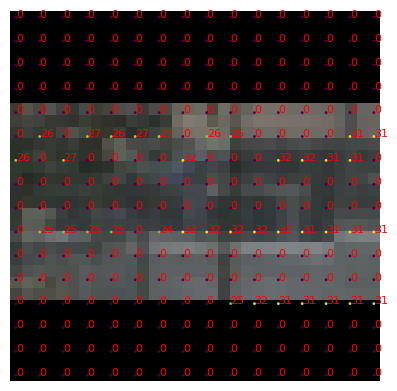

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
predictions: [[-5.4402785   0.4190469  33.6782      2.6798573   4.101859    1.8751796
   1.1476266  -0.03596364 -0.07687157]]
center: [-5.4402785  0.4190469 33.6782   ]
size: [2.6798573 4.101859  1.8751796]
euler: [ 1.1476266  -0.03596364 -0.07687157]
category:  truck
min_x: 962 min_y: 466 max_x: 1085 max_y: 538


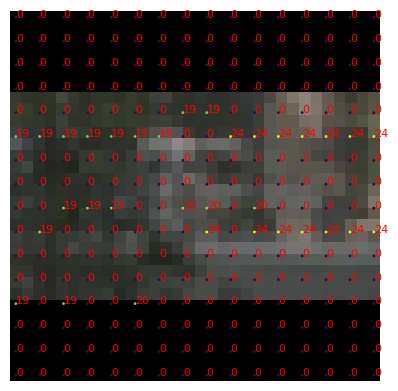

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predictions: [[ 4.7912865  -0.13989878 33.74871     3.6108115   5.5288844   1.4872612
   0.962503   -0.46508217  0.19724949]]
center: [ 4.7912865  -0.13989878 33.74871   ]
size: [3.6108115 5.5288844 1.4872612]
euler: [ 0.962503   -0.46508217  0.19724949]
category:  truck
min_x: 886 min_y: 464 max_x: 1008 max_y: 537


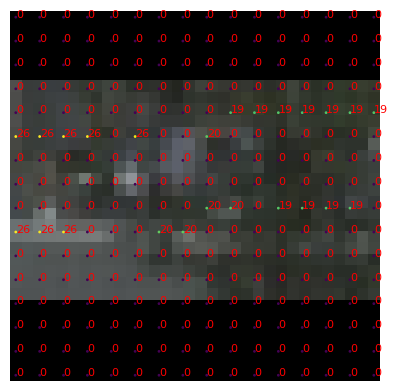

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
predictions: [[ 2.5648065  -0.07851301 33.00773     3.2067323   5.1261477   1.8660105
   1.0005593  -0.9023763   0.40608132]]
center: [ 2.5648065  -0.07851301 33.00773   ]
size: [3.2067323 5.1261477 1.8660105]
euler: [ 1.0005593  -0.9023763   0.40608132]
category:  truck
min_x: 503 min_y: 448 max_x: 645 max_y: 529


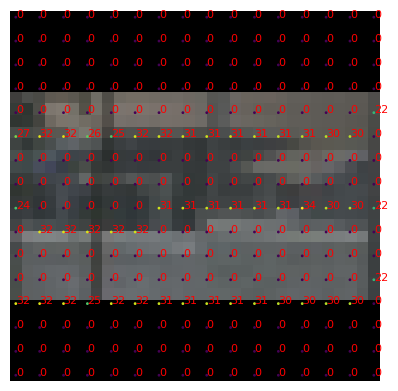

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
predictions: [[-3.3676121e+00  1.5386207e+00  2.5313984e+01  2.5766277e+00
   5.3873792e+00  1.6997228e+00 -9.1331005e-02 -2.4345275e-02
  -3.9710751e-01]]
center: [-3.3676121  1.5386207 25.313984 ]
size: [2.5766277 5.387379  1.6997228]
euler: [-0.09133101 -0.02434528 -0.3971075 ]
category:  truck
min_x: 1171 min_y: 465 max_x: 1321 max_y: 557


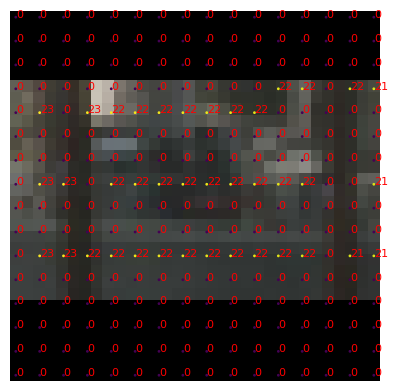

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
predictions: [[ 3.540794   -0.75279635 44.127693    4.159628    6.130146    2.0095024
   3.1984437  -0.7974185   2.4516115 ]]
center: [ 3.540794   -0.75279635 44.127693  ]
size: [4.159628  6.130146  2.0095024]
euler: [ 3.1984437 -0.7974185  2.4516115]
category:  truck
min_x: 1075 min_y: 474 max_x: 1201 max_y: 546


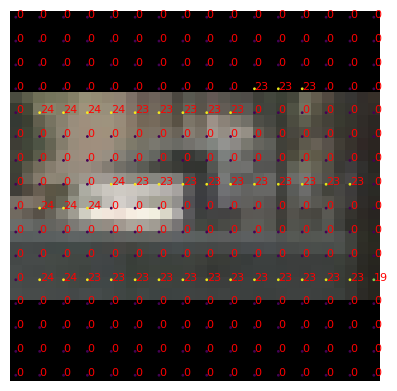

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predictions: [[ 4.376927  -0.251167  44.6822     4.2136626  5.6590123  2.307931
   0.7898323 -0.4286499  1.3325498]]
center: [ 4.376927 -0.251167 44.6822  ]
size: [4.2136626 5.6590123 2.307931 ]
euler: [ 0.7898323 -0.4286499  1.3325498]
category:  truck
min_x: 560 min_y: 454 max_x: 725 max_y: 533


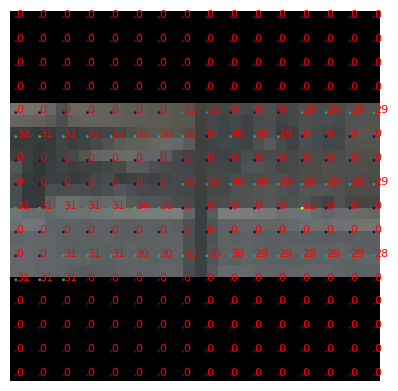

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
predictions: [[-4.0075369e+00  4.9236577e-02  3.3775368e+01  2.8509371e+00
   6.5824618e+00  1.5483316e+00 -1.6856901e-01 -3.1987042e-03
   2.5132096e+00]]
center: [-4.007537    0.04923658 33.775368  ]
size: [2.8509371 6.582462  1.5483316]
euler: [-0.16856901 -0.0031987   2.5132096 ]
category:  truck
min_x: 730 min_y: 458 max_x: 891 max_y: 536


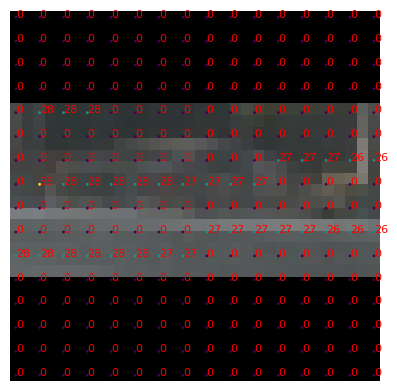

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
predictions: [[-0.23828693 -0.07655876 36.452015    2.5666523   4.4261384   2.7714732
   1.8570373  -0.4339814   0.7167099 ]]
center: [-0.23828693 -0.07655876 36.452015  ]
size: [2.5666523 4.4261384 2.7714732]
euler: [ 1.8570373 -0.4339814  0.7167099]
predicted boxes:


<Figure size 640x480 with 0 Axes>

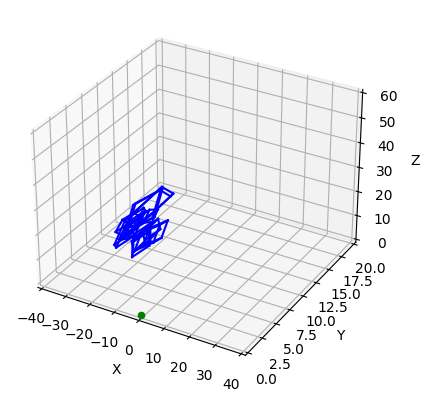

original boxes:


<Figure size 640x480 with 0 Axes>

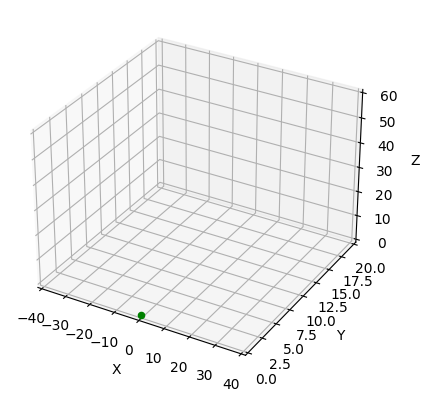

plot with boxes without any changes


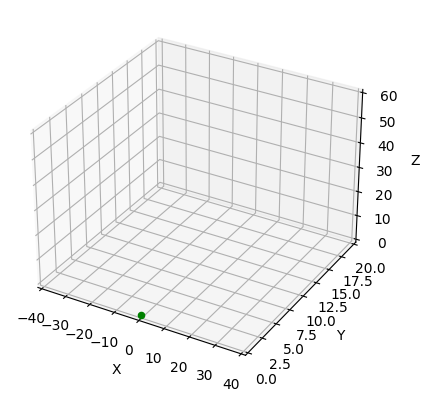

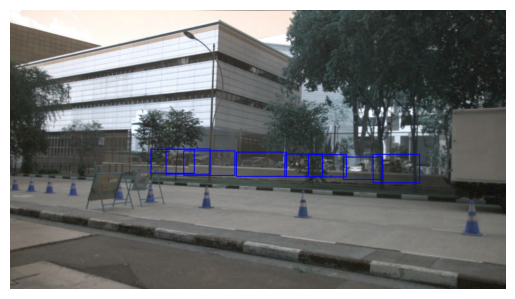

detect_dual: weights=['/home/nuno120/Downloads/results_DownlOAD/hva_exp13_imgs1200/epoch78.pt'], source=/home/nuno120/Documents/SCRIPTIE/data/sets/nuscenes/samples/CAM_FRONT_RIGHT/n015-2018-07-24-11-22-45+0800__CAM_FRONT_RIGHT__1532402940170339.jpg, data=yolov9/data/coco128.yaml, imgsz=[1216, 1216], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=True, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/home/nuno120/Documents/SCRIPTIE/yolov9/results, name=latest_results, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLO 🚀 2024-4-20 Python-3.10.0 torch-2.3.0+cu121 CPU

Fusing layers... 
yolov9-c summary: 604 layers, 50719068 parameters, 0 gradients, 236.7 GFLOPs
image 1/1 /home/nuno120/Documents/SCRIPTIE/data/sets/nuscenes/samples/CAM_FRONT_RIGHT/n015-2018-07-24-11-22-45+0800__CAM_FRONT_RIGHT__1532402940170339.jpg:

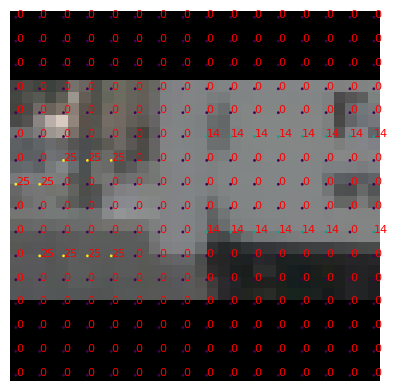

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
predictions: [[-0.676651   -0.06125392 35.89858     2.773665    4.777389    2.3908207
   0.6658686  -0.4252754   1.2115606 ]]
center: [-0.676651   -0.06125392 35.89858   ]
size: [2.773665  4.777389  2.3908207]
euler: [ 0.6658686 -0.4252754  1.2115606]
category:  truck
min_x: 106 min_y: 462 max_x: 242 max_y: 534


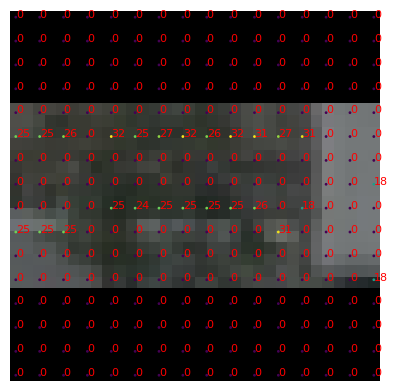

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
predictions: [[-20.708218     0.59487104  40.37262      2.2676525    5.189455
    1.5145731   -0.1186792   -0.0675405   -0.5559883 ]]
center: [-20.708218     0.59487104  40.37262   ]
size: [2.2676525 5.189455  1.5145731]
euler: [-0.1186792 -0.0675405 -0.5559883]
category:  truck
min_x: 0 min_y: 450 max_x: 66 max_y: 523


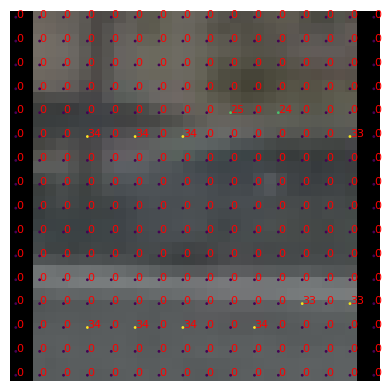

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predictions: [[-17.852201    -0.29219598  30.546371     2.621191     4.893827
    0.64246356  -0.69786656  -0.41655722   3.2753782 ]]
center: [-17.852201    -0.29219598  30.546371  ]
size: [2.621191   4.893827   0.64246356]
euler: [-0.69786656 -0.41655722  3.2753782 ]
category:  truck
min_x: 632 min_y: 488 max_x: 740 max_y: 552


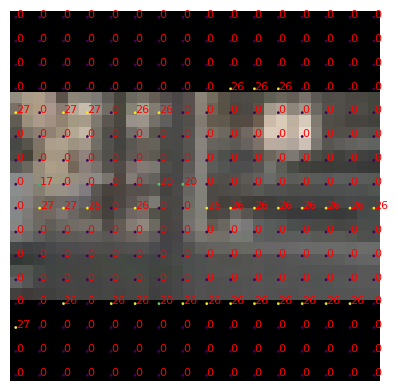

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
predictions: [[-2.7730927  -0.04834573 35.267296    2.5183723   4.593304    0.60126853
   0.5764661  -0.35630313 -0.5863037 ]]
center: [-2.7730927  -0.04834573 35.267296  ]
size: [2.5183723  4.593304   0.60126853]
euler: [ 0.5764661  -0.35630313 -0.5863037 ]
category:  truck
min_x: 0 min_y: 457 max_x: 136 max_y: 533


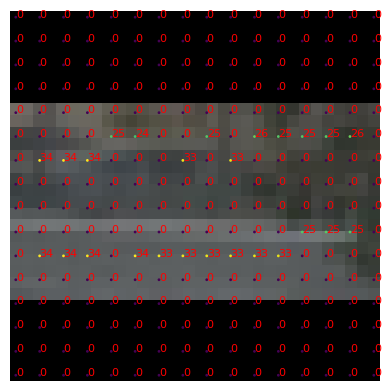

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
predictions: [[-24.947117    -0.1468444   44.6979       2.7646692    5.1070232
    0.57367843  -1.2091445   -0.05828691   1.3738648 ]]
center: [-24.947117   -0.1468444  44.6979   ]
size: [2.7646692  5.1070232  0.57367843]
euler: [-1.2091445  -0.05828691  1.3738648 ]
category:  truck
min_x: 680 min_y: 486 max_x: 833 max_y: 564


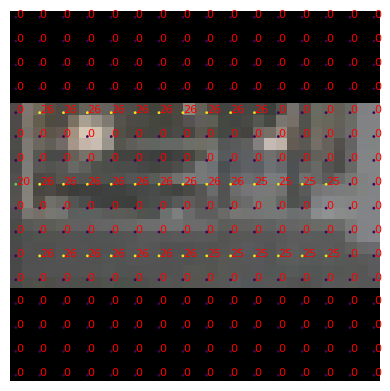

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
predictions: [[-2.3975489e+00  7.1775550e-01  3.1012800e+01  3.0229461e+00
   5.1617084e+00  2.5395234e+00 -4.3711201e-03 -5.8311480e-01
   1.5281885e+00]]
center: [-2.397549   0.7177555 31.0128   ]
size: [3.0229461 5.1617084 2.5395234]
euler: [-0.00437112 -0.5831148   1.5281885 ]
category:  truck
min_x: 1126 min_y: 493 max_x: 1597 max_y: 739


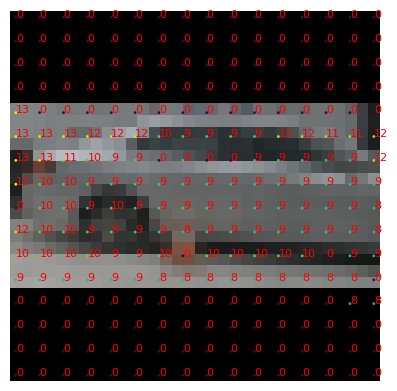

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
predictions: [[ 1.848303   -0.3197286  14.94312     2.0593326   5.2052994   2.2525733
  -0.38019526 -0.6051153  -0.39459717]]
center: [ 1.848303  -0.3197286 14.94312  ]
size: [2.0593326 5.2052994 2.2525733]
euler: [-0.38019526 -0.6051153  -0.39459717]
predicted boxes:


<Figure size 640x480 with 0 Axes>

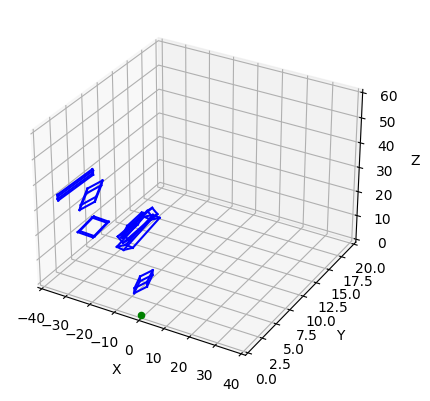

original boxes:
vehicle.car
[ 5.05529847  0.832641   10.03656985]
[1.745 4.663 1.482]
-0.710 -0.678i -0.143j +0.129k
----------------


<Figure size 640x480 with 0 Axes>

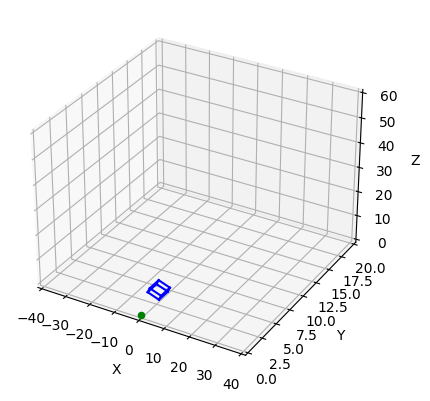

plot with boxes without any changes


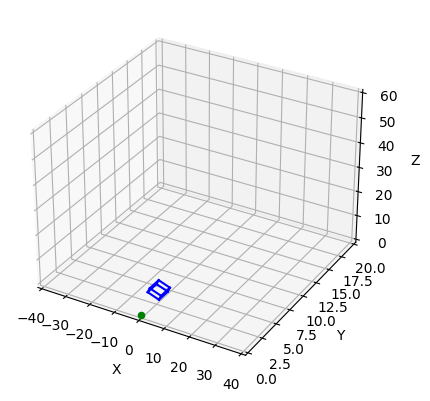

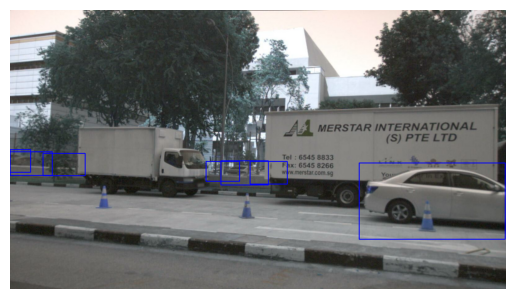

detect_dual: weights=['/home/nuno120/Downloads/results_DownlOAD/hva_exp13_imgs1200/epoch78.pt'], source=/home/nuno120/Documents/SCRIPTIE/data/sets/nuscenes/samples/CAM_FRONT_RIGHT/n015-2018-07-24-11-22-45+0800__CAM_FRONT_RIGHT__1532402935170339.jpg, data=yolov9/data/coco128.yaml, imgsz=[1216, 1216], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=True, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/home/nuno120/Documents/SCRIPTIE/yolov9/results, name=latest_results, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLO 🚀 2024-4-20 Python-3.10.0 torch-2.3.0+cu121 CPU

Fusing layers... 
yolov9-c summary: 604 layers, 50719068 parameters, 0 gradients, 236.7 GFLOPs
image 1/1 /home/nuno120/Documents/SCRIPTIE/data/sets/nuscenes/samples/CAM_FRONT_RIGHT/n015-2018-07-24-11-22-45+0800__CAM_FRONT_RIGHT__1532402935170339.jpg:

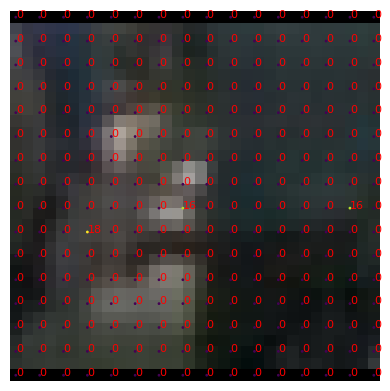

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
predictions: [[-24.035805    -0.0527085   45.830036     2.031105     4.577961
    1.2130462   -0.16012333  -0.11096763  -0.38984987]]
center: [-24.035805   -0.0527085  45.830036 ]
size: [2.031105  4.577961  1.2130462]
euler: [-0.16012333 -0.11096763 -0.38984987]
category:  truck
min_x: 274 min_y: 474 max_x: 346 max_y: 534


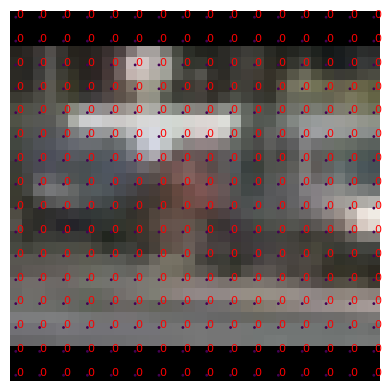

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predictions: [[-2.1176311e+01 -2.9499108e-02  5.0589298e+01  2.3546398e+00
   4.9344773e+00  1.4602953e+00  1.5820377e-01 -1.0756691e-01
  -5.8930182e-01]]
center: [-2.1176311e+01 -2.9499108e-02  5.0589298e+01]
size: [2.3546398 4.9344773 1.4602953]
euler: [ 0.15820377 -0.10756691 -0.5893018 ]
category:  truck
min_x: 297 min_y: 472 max_x: 380 max_y: 537


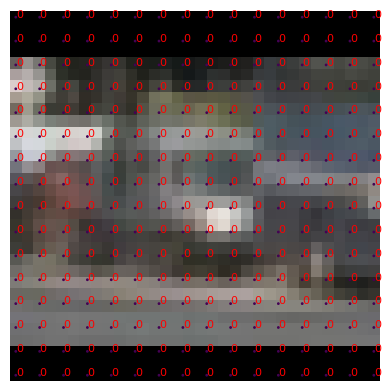

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
predictions: [[-16.86225      1.1145111   43.912563     2.2004056    4.670003
    1.6001308    1.5191466   -0.12899892  -1.1357799 ]]
center: [-16.86225     1.1145111  43.912563 ]
size: [2.2004056 4.670003  1.6001308]
euler: [ 1.5191466  -0.12899892 -1.1357799 ]
category:  truck
min_x: 1554 min_y: 495 max_x: 1599 max_y: 592


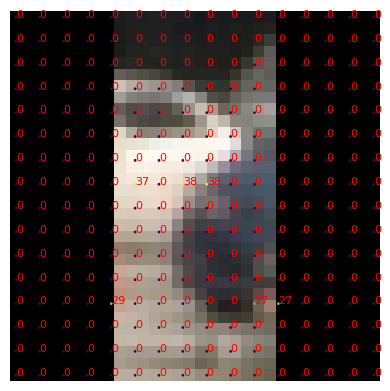

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
predictions: [[ 7.9960613  -1.8136014  64.856346    3.1656795   5.626298    2.2616718
   1.8462497  -1.3591002   0.42362264]]
center: [ 7.9960613 -1.8136014 64.856346 ]
size: [3.1656795 5.626298  2.2616718]
euler: [ 1.8462497  -1.3591002   0.42362264]
category:  truck
min_x: 203 min_y: 473 max_x: 273 max_y: 527


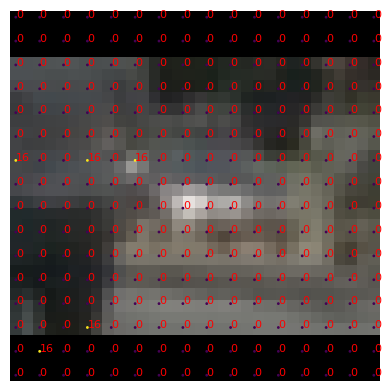

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predictions: [[-24.804726    -0.06966181  54.94111      2.1212661    4.598562
    1.1600083    0.7643861   -0.14170568  -0.5439796 ]]
center: [-24.804726    -0.06966181  54.94111   ]
size: [2.1212661 4.598562  1.1600083]
euler: [ 0.7643861  -0.14170568 -0.5439796 ]
category:  truck
min_x: 248 min_y: 474 max_x: 318 max_y: 532


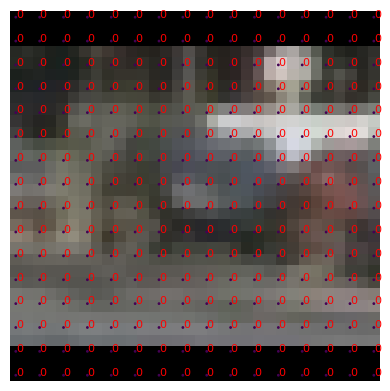

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
predictions: [[-2.2259201e+01 -1.5011033e-03  5.2145947e+01  2.2384050e+00
   4.6661568e+00  1.5103506e+00 -1.2983230e-01 -1.5143487e-01
  -2.9549646e-01]]
center: [-2.2259201e+01 -1.5011033e-03  5.2145947e+01]
size: [2.238405  4.666157  1.5103506]
euler: [-0.1298323  -0.15143487 -0.29549646]
category:  truck
min_x: 1457 min_y: 495 max_x: 1596 max_y: 577


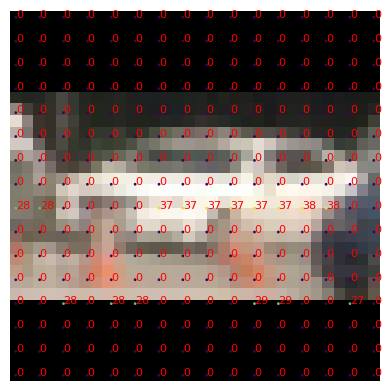

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
predictions: [[ 4.7048864  -0.70233065 56.310856    4.8478255   7.0489635   2.8562257
  -0.6833671  -0.98979205  4.217557  ]]
center: [ 4.7048864  -0.70233065 56.310856  ]
size: [4.8478255 7.0489635 2.8562257]
euler: [-0.6833671  -0.98979205  4.217557  ]
category:  truck
min_x: 1254 min_y: 488 max_x: 1427 max_y: 574


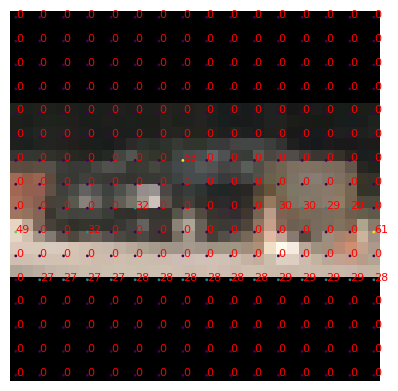

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
predictions: [[ 5.405264   -0.684825   41.49969     3.785064    7.4950128   2.6376362
  -0.38873273 -0.5912398  -0.14664215]]
center: [ 5.405264 -0.684825 41.49969 ]
size: [3.785064  7.4950128 2.6376362]
euler: [-0.38873273 -0.5912398  -0.14664215]
category:  truck
min_x: 920 min_y: 463 max_x: 1063 max_y: 587


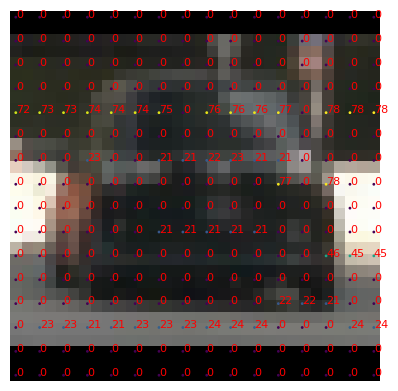

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
predictions: [[ 0.466107   -0.29171592 28.61159     4.971641    7.0920663   1.1413257
   2.898334   -1.0345464   3.8755162 ]]
center: [ 0.466107   -0.29171592 28.61159   ]
size: [4.971641  7.0920663 1.1413257]
euler: [ 2.898334  -1.0345464  3.8755162]
predicted boxes:


<Figure size 640x480 with 0 Axes>

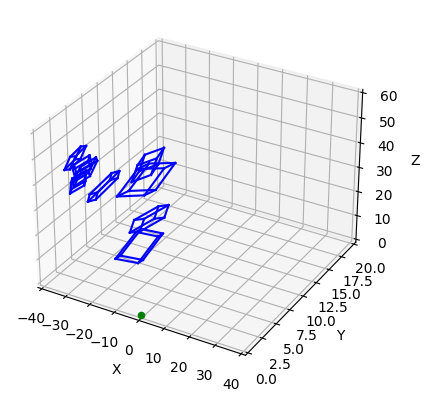

original boxes:
vehicle.car
[ 3.30238785  0.50011711 23.36423401]
[1.708 4.01  1.631]
-0.508 -0.508i +0.485j -0.499k
----------------
vehicle.car
[19.25455813  0.92986535 29.05835878]
[1.939 4.819 1.736]
-0.214 -0.201i -0.673j +0.679k
----------------
vehicle.car
[22.25424249  1.17364561 38.80381931]
[1.972 4.698 1.581]
-0.222 -0.209i -0.670j +0.677k
----------------
vehicle.car
[28.95376782  0.89520331 43.74139627]
[2.018 5.582 2.132]
-0.226 -0.213i -0.669j +0.675k
----------------
vehicle.car
[14.15199614  0.94319895 33.47797475]
[1.875 4.363 1.441]
-0.222 -0.209i -0.670j +0.677k
----------------


<Figure size 640x480 with 0 Axes>

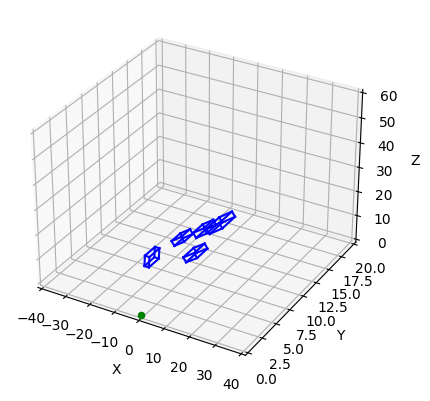

plot with boxes without any changes


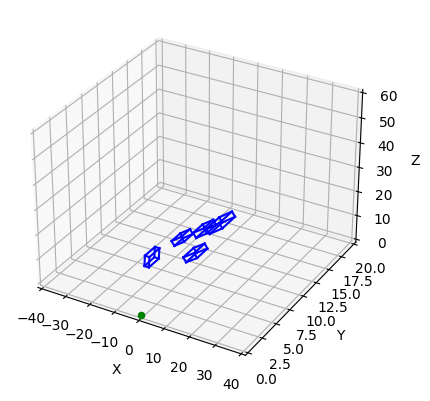

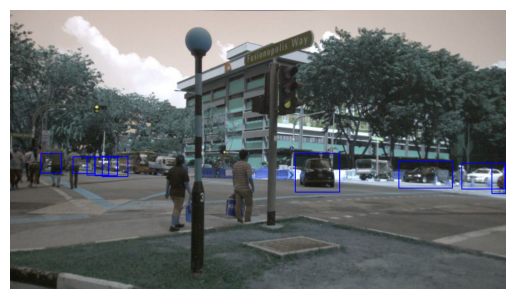

detect_dual: weights=['/home/nuno120/Downloads/results_DownlOAD/hva_exp13_imgs1200/epoch78.pt'], source=/home/nuno120/Documents/SCRIPTIE/data/sets/nuscenes/samples/CAM_FRONT_RIGHT/n008-2018-08-28-16-43-51-0400__CAM_FRONT_RIGHT__1535489308870482.jpg, data=yolov9/data/coco128.yaml, imgsz=[1216, 1216], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=True, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/home/nuno120/Documents/SCRIPTIE/yolov9/results, name=latest_results, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLO 🚀 2024-4-20 Python-3.10.0 torch-2.3.0+cu121 CPU

Fusing layers... 
yolov9-c summary: 604 layers, 50719068 parameters, 0 gradients, 236.7 GFLOPs
image 1/1 /home/nuno120/Documents/SCRIPTIE/data/sets/nuscenes/samples/CAM_FRONT_RIGHT/n008-2018-08-28-16-43-51-0400__CAM_FRONT_RIGHT__1535489308870482.jpg:

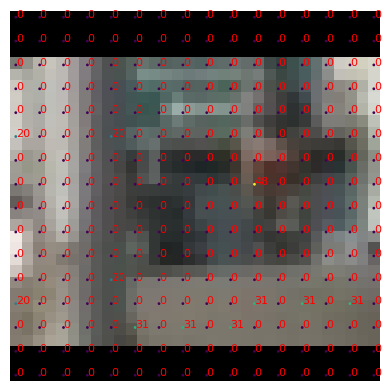

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
predictions: [[ 2.7545412  -1.1223197  31.12085     2.26651     5.123025    1.7511576
  -0.09129313 -1.1548077   1.9240713 ]]
center: [ 2.7545412 -1.1223197 31.12085  ]
size: [2.26651   5.123025  1.7511576]
euler: [-0.09129313 -1.1548077   1.9240713 ]
category:  truck
min_x: 1053 min_y: 414 max_x: 1143 max_y: 473


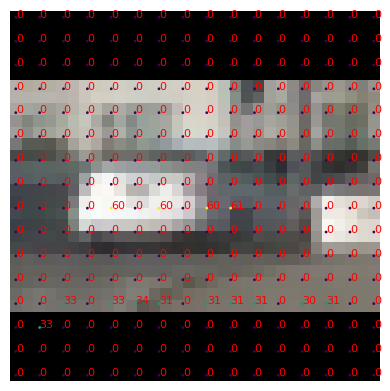

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
predictions: [[ 3.8872612  -0.98565054 40.256924    2.8927455   5.575159    2.577761
   2.5824018  -1.0861342   2.8410206 ]]
center: [ 3.8872612  -0.98565054 40.256924  ]
size: [2.8927455 5.575159  2.577761 ]
euler: [ 2.5824018 -1.0861342  2.8410206]
category:  truck
min_x: 789 min_y: 406 max_x: 923 max_y: 480


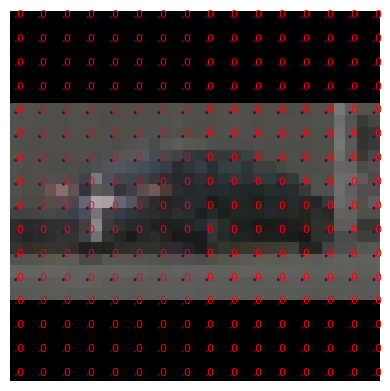

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predictions: [[ 1.922723   -0.24887316 27.827742    2.1270447   3.9129813   1.442307
  -0.09466882 -0.6543507   1.7744447 ]]
center: [ 1.922723   -0.24887316 27.827742  ]
size: [2.1270447 3.9129813 1.442307 ]
euler: [-0.09466882 -0.6543507   1.7744447 ]
category:  truck
min_x: 599 min_y: 407 max_x: 761 max_y: 492


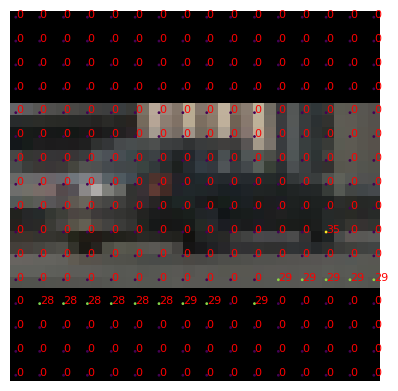

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
predictions: [[-2.3221557  -0.32372174 32.705925    2.3808188   4.7531      2.282391
   1.4792614  -0.6638759   1.5158386 ]]
center: [-2.3221557  -0.32372174 32.705925  ]
size: [2.3808188 4.7531    2.282391 ]
euler: [ 1.4792614 -0.6638759  1.5158386]
category:  truck
min_x: 148 min_y: 413 max_x: 458 max_y: 533


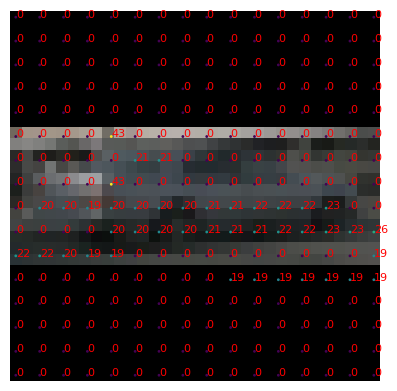

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
predictions: [[-9.044646   -0.03894139 24.233038    2.2338817   5.948625    1.0000015
  -0.05304651  0.20967482  2.860406  ]]
center: [-9.044646   -0.03894139 24.233038  ]
size: [2.2338817 5.948625  1.0000015]
euler: [-0.05304651  0.20967482  2.860406  ]
predicted boxes:


<Figure size 640x480 with 0 Axes>

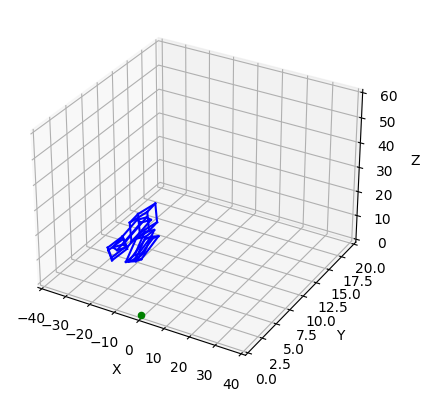

original boxes:
vehicle.car
[13.95323671 -0.36518112 62.58629073]
[2.016 4.752 1.758]
0.628 +0.607i -0.345j +0.344k
----------------
vehicle.car
[-3.59861711 -0.17742737 32.47610552]
[2.043 4.464 1.567]
0.611 +0.590i -0.374j +0.374k
----------------
vehicle.car
[-9.0319217   0.31400367 22.18418078]
[2.089 4.72  1.473]
0.617 +0.596i -0.363j +0.363k
----------------
vehicle.car
[ 1.45126027 -0.32296827 43.93673749]
[2.016 4.755 1.487]
0.615 +0.594i -0.366j +0.366k
----------------


<Figure size 640x480 with 0 Axes>

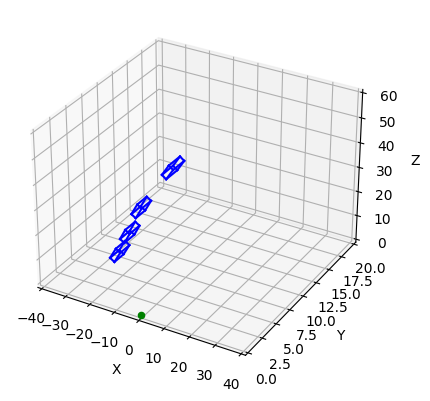

plot with boxes without any changes


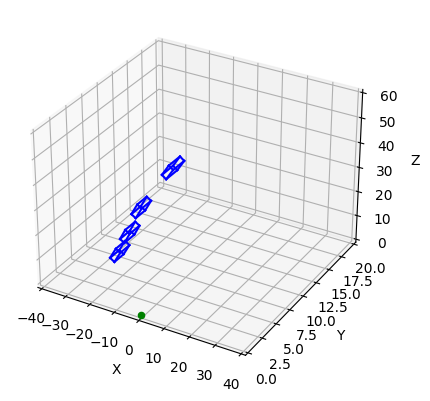

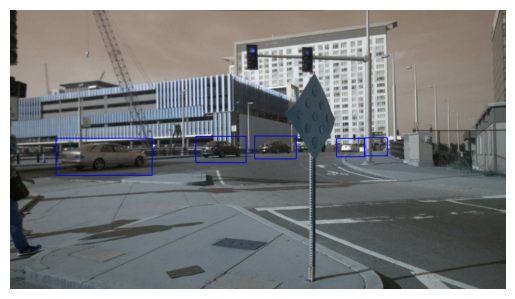

"\n\n    #laod the model\n    model = keras.models.load_model('/home/nuno120/Documents/SCRIPTIE/3D_predictor_model.h5')\n\n    #load yolov9 model\n    import os \n    !git clone https://github.com/SkalskiP/yolov9.git\n    %cd yolov9\n    !pip install -r requirements.txt -q\n    !python /home/nuno120/Documents/SCRIPTIE/yolov9/detect_dual.py --weights {weights_path} --conf {conf_threshold} --source {cam_filename} --save-txt --save-conf --save-crop --project /home/nuno120/Documents/SCRIPTIE/yolov9/results --name latest_results --exist-ok \n\n"

In [15]:
import os
import cv2
import glob


# Function to convert YOLO format to bounding box coordinates
def convert_from_yolo_format(yolo_box, image_width, image_height):
    x_center = yolo_box[0]
    y_center = yolo_box[1]
    normalized_width = yolo_box[2]
    normalized_height = yolo_box[3]
    width = normalized_width * image_width
    height = normalized_height * image_height
    x_min = (x_center - normalized_width / 2) * image_width
    y_min = (y_center - normalized_height / 2) * image_height
    x_max = x_min + width
    y_max = y_min + height
    return round(x_min), round(y_min), round(x_max), round(y_max)



def get_mAP(sample_number):
    model = load_model_with_custom_objects('/home/nuno120/Documents/SCRIPTIE/model_car_epoch_250_camfrontright.keras')
    weights_path = "/home/nuno120/Downloads/results_DownlOAD/hva_exp13_imgs1200/epoch78.pt"
    conf_threshold = 0.1
    save_txt_path = "/home/nuno120/Downloads/data/test.txt"
    device = "cpu"
    latest_results = "/home/nuno120/Documents/SCRIPTIE/yolov9/results/latest_results"
    #empty the folder
    os.system('rm -rf /home/nuno120/Documents/SCRIPTIE/yolov9/results/latest_results')
    
    sample = nusc.sample[sample_number]
    camera_names = [
        'CAM_FRONT',
        'CAM_FRONT_LEFT',
        'CAM_FRONT_RIGHT',
        'CAM_BACK',
        'CAM_BACK_LEFT',
        'CAM_BACK_RIGHT'
    ]
    camera_names = ['CAM_FRONT_RIGHT']
    
    for camera_name in camera_names:
        camera_token = nusc.sample[sample_number]['data']['%s' %camera_name] #one camera, get the camera token 
        path, boxes, anns, intrinsic_matrix = get_sample_data(nusc,'%s' %camera_token) #gets data for one image
        pointsensor_token = nusc.sample[sample_number]['data']['LIDAR_TOP']
        points, coloring, im = map_lidar_to_image(nusc, sample_number, camera_name, pointsensor_token, camera_token)
        image = cv2.imread(path)

        image_height, image_width = image.shape[0], image.shape[1]
        !python /home/nuno120/Documents/SCRIPTIE/yolov9/detect_dual.py --weights {weights_path} --imgsz 1216 --conf {conf_threshold} --source {path} --save-txt --save-conf --save-crop --project /home/nuno120/Documents/SCRIPTIE/yolov9/results --name latest_results --exist-ok 
        #open the latest_results/labels folder and find the file with the camera name in it
        classes, confidences, x_min, x_max, y_min, y_max= [],[],[],[],[],[]
        for filename in os.listdir(latest_results+'/labels'):
            print(filename)
            if camera_name in filename:
                axisses, centers, sizes, orientations = [], [], [], []
                #label file found, open it and read the boxes
                with open(latest_results+'/labels/'+filename, 'r') as f:
                    lines = f.readlines()
                    for line in lines:
                        #split on spaces
                        line = line.split()
                        category, x, y, w, h,conf = int(line[0]), float(line[1]), float(line[2]), float(line[3]), float(line[4]), float(line[5])
                        if category == 3:
                            print('category: ', 'truck')
                            classes.append(category)
                            confidences.append(conf)
                            #now convert the boxes to xmin,ymin, xmax, ymax
                            min_x, min_y, max_x, max_y = convert_from_yolo_format([x,y,w, h], image_width, image_height)
                            
                            #now make the box somewhat bigger if it fits in the image
                            pixels = 15
                            if min_x > pixels:
                                min_x -= pixels
                            if min_y > pixels:
                                min_y -= pixels
                            if max_x < image_width - pixels:
                                max_x += pixels
                            if max_y < image_height - pixels:
                                max_y += pixels
                            print('min_x:', min_x, 'min_y:', min_y, 'max_x:', max_x, 'max_y:', max_y)

                            x_min.append(min_x)
                            y_min.append(min_y)
                            x_max.append(max_x)
                            y_max.append(max_y)
            

                            

                            # Ensure the bounding box is within the image boundaries
                            min_x = max(0, min_x)
                            
                            max_x = min(image_width, max_x)
                            
                            min_y = max(0, min_y)
                            max_y = min(image_height, max_y)
                            #ensure it also is not just zeros
                            if min_x and max_x and min_y and max_y == 0:
                                continue

                            if min_x >= max_x or min_y >= max_y:
                                continue

                            points_in_box = []
                            new_coloring = []
                            for j in range(len(points[0])):
                                if min_x <= points[0][j] <= max_x and min_y <= points[1][j] <= max_y:
                                    points_in_box.append(points[:, j])
                                    new_coloring.append(coloring[j])
                            
                            points_in_box = np.array(points_in_box)
                            
                            if len(points_in_box) > 0:
                                plt.scatter(points_in_box[:, 0], points_in_box[:, 1], c=new_coloring, s=1)
                            
                            cropped_image = np.array(im)[round(min_y):round(max_y), round(min_x):round(max_x)]
                            if cropped_image.size == 0:
                                continue
                            
                            if len(points_in_box) > 0:
                                points_in_box[:, 0] -= round(min_x)
                                points_in_box[:, 1] -= round(min_y)
                            """plt.clf()
                            plt.imshow(cropped_image)
                            if len(points_in_box) > 0:
                                plt.scatter(points_in_box[:, 0], points_in_box[:, 1], c=new_coloring, s=1)
                            plt.axis('off')
                            plt.show()

                            plt.clf()
                            """
                            
                            if cropped_image.shape[0] < cropped_image.shape[1]:
                                scale_factor = 32 / cropped_image.shape[1]
                                new_width = 32
                                new_height = int(32 * cropped_image.shape[0] / cropped_image.shape[1])
                                cropped_image = cv2.resize(cropped_image, (new_width, new_height), interpolation=cv2.INTER_AREA)
                                
                                if len(points_in_box) > 0:
                                    points_in_box[:, 0] *= scale_factor
                                    points_in_box[:, 1] *= scale_factor
                                
                                pad = 32 - cropped_image.shape[0]
                                top_pad = round(pad / 2)
                                bottom_pad = pad - top_pad
                                cropped_image = cv2.copyMakeBorder(cropped_image, top_pad, bottom_pad, 0, 0, cv2.BORDER_CONSTANT, value=[0, 0, 0])
                                
                                if len(points_in_box) > 0:
                                    points_in_box[:, 1] += top_pad
                            else:
                                scale_factor = 32 / cropped_image.shape[0]
                                new_height = 32
                                new_width = int(32 * cropped_image.shape[1] / cropped_image.shape[0])
                                cropped_image = cv2.resize(cropped_image, (new_width, new_height), interpolation=cv2.INTER_AREA)
                                
                                if len(points_in_box) > 0:
                                    points_in_box[:, 0] *= scale_factor
                                    points_in_box[:, 1] *= scale_factor
                                
                                pad = 32 - cropped_image.shape[1]
                                left_pad = round(pad / 2)
                                right_pad = pad - left_pad
                                cropped_image = cv2.copyMakeBorder(cropped_image, 0, 0, left_pad, right_pad, cv2.BORDER_CONSTANT, value=[0, 0, 0])
                                
                                if len(points_in_box) > 0:
                                    points_in_box[:, 0] += left_pad

                            if len(points_in_box) > 0:
                                points_in_box, new_coloring = make_grid(cropped_image, points_in_box, new_coloring, shape=(16, 16))
                            else:
                                #print('No points in box')
                                #evenly divide the image into 16x16 grid over a 32x32 image
                                x_coords = np.linspace(0, 32 - 1, 16)
                                y_coords = np.linspace(0, 32 - 1, 16)
                                grid_points_x, grid_points_y = np.meshgrid(x_coords, y_coords)
                                points_in_box = np.stack((grid_points_x.flatten(), grid_points_y.flatten()), axis=1)
                                #print('points in box shape:', points_in_box.shape)
                                new_coloring = np.zeros(16 * 16)
                            
                            plt.clf()
                            plt.imshow(cropped_image)
                            if len(points_in_box) > 0:
                                plt.scatter(points_in_box[:, 0], points_in_box[:, 1], c=new_coloring, s=1)
                                for idx, point in enumerate(points_in_box):
                                    plt.text(point[0], point[1], str(int(new_coloring[idx])), color='red', fontsize=8)
                            plt.axis('off')
                            plt.show()
                            plt.clf()
                            #now feed the new_coloring and the image to the neural network and get the 3d bounding box
                            #convert cropped image to gray
                            cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
                            #expend the dimension
                            cropped_image = np.expand_dims(cropped_image, axis=2)
                            cropped_image = np.expand_dims(cropped_image, axis=0)
                            # Expand the dimensions of other inputs to match the batch size
                            new_coloring = np.expand_dims(new_coloring, axis=0)
                            box_2D_input = np.expand_dims(np.array([float(min_x), float(max_x), float(min_y), float(max_y)]), axis=0)
                            #print(cropped_image.shape)
                            #print(points_in_box.shape)
                            #print(new_coloring.shape)
                            #print(box_2D_input.shape)
                            predictions = model.predict({'image_input': cropped_image, 'distances_input': new_coloring, 'box_2D_input': box_2D_input})
                            #print('predictions:', predictions)

                            #now visualize the 3d bounding box
                            #get the 3d bounding box
                            print('predictions:', predictions)
                            center = predictions[0][0:3]
                            size = predictions[0][3:6]
                            euler = predictions[0][6:9]
                            print('center:', center)
                            print('size:', size)
                            print('euler:', euler)
                            #print(orientation)
                            #quaternion = get_quaternion_from_euler(orientation[0], orientation[1], orientation[2])
                            #print('orientation:', orientation)
                            #orientation = Quaternion(axis=quaternion[:3], angle=quaternion[3]) #angle=np.deg2rad(orientation[3])
                            
                            
                            x,y,z,w = get_quaternion_from_euler(euler[0], euler[1], euler[2])
                            orientation = Quaternion(w,x,y,z)
                            #orientation = Quaternion()
                            #axis = predictions[0][6:9]
                            #angle = predictions[0][9]

                            #print('center:', center)
                            #print('size:', size)
                            #print('quaternion', orientation)
                            #print('axis:', axis)
                            #print('angle:', angle)
                            #axisses.append(axis)
                            centers.append(center)
                            sizes.append(size)
                            
                            orientations.append(orientation)
                plt.clf()
                print('predicted boxes:')
                visualize_boxes_outcome(centers, sizes, orientations)
                plt.clf()
                print('original boxes:')
                #filter on vehicle.truck:
                trucks = []
                for box in boxes:
                    if box.name == 'vehicle.car':
                        print(box.name)
                        print(box.center)
                        print(box.wlh)
                        print(box.orientation)
                        print('----------------')
                        trucks.append(box)
                visualize_boxes(trucks)

                        #now visualize the 3d bounding box
                        





        #now we have the boxes for the image
        #draww them on the image
        color = (0,0,255)
        thickness = 2
        for i in range(len(classes)):
            image = cv2.rectangle(image, (x_min[i], y_min[i]), (x_max[i], y_max[i]), color, thickness)
        plt.imshow(image)
        plt.axis('off')
        plt.show()


        

                        


        
        # Draw the bounding box on the image
        color = (255, 0, 0)  # Bounding box color
        thickness = 2  # Bounding box thickness
        #image_rgb = cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, thickness)
    
    # Display the image with bounding boxes using Matplotlib
    #plt.imshow(image_rgb)
    #plt.axis('off')
    #plt.show()






                        
                        



                    






        
        
        #model = keras.models.load_model('/home/nuno120/Documents/SCRIPTIE/3D_predictor_model.h5')
    

get_mAP(35)
get_mAP(25)
get_mAP(15)
get_mAP(105)

"""

    #laod the model
    model = keras.models.load_model('/home/nuno120/Documents/SCRIPTIE/3D_predictor_model.h5')

    #load yolov9 model
    import os 
    !git clone https://github.com/SkalskiP/yolov9.git
    %cd yolov9
    !pip install -r requirements.txt -q
    !python /home/nuno120/Documents/SCRIPTIE/yolov9/detect_dual.py --weights {weights_path} --conf {conf_threshold} --source {cam_filename} --save-txt --save-conf --save-crop --project /home/nuno120/Documents/SCRIPTIE/yolov9/results --name latest_results --exist-ok 

"""
    


In [6]:
import numpy as np
from pyquaternion import Quaternion
import glob 


my_scene = nusc.scene[0]
first_sample_token = my_scene['first_sample_token']
current_sample_token = first_sample_token
#now run yolo on the image
weights_path = "/home/nuno120/Downloads/results_DownlOAD/hva_exp13_imgs1200/epoch78.pt"
conf_threshold = 0.5
save_txt_path = "/home/nuno120/Downloads/data/test.txt"
device = "cpu"
latest_results = "/home/nuno120/Documents/SCRIPTIE/yolov9/results/latest_results"

while not current_sample_token == "":
    current_sample = nusc.get('sample', current_sample_token)
    current_sample_token = current_sample['next']
    
    # Specify camera keys
    camera_keys = ['CAM_FRONT', 'CAM_BACK', 'CAM_BACK_LEFT', 'CAM_BACK_RIGHT', 'CAM_FRONT_LEFT', 'CAM_FRONT_RIGHT']

    lidar_token = current_sample['data']['LIDAR_TOP']
    sd_rec = nusc.get('sample_data', current_sample['data']['LIDAR_TOP'])
    cs_record = nusc.get('calibrated_sensor',
                        sd_rec['calibrated_sensor_token'])
    pose_record = nusc.get('ego_pose', sd_rec['ego_pose_token'])
    #get the boxes in the ego frame 
    lidar_path, boxes, _ = nusc.get_sample_data(lidar_token)
    #print('pose_record: ', pose_record)

    info = {
            'lidar_path': lidar_path,
            'token': current_sample['token'],
            'prev': current_sample['prev'],
            'next': current_sample['next'],
            'sweeps': [],
            'cams': dict(),
            'scene_token': current_sample['scene_token'],
            'lidar2ego_translation': cs_record['translation'],
            'lidar2ego_rotation': cs_record['rotation'],
            'ego2global_translation': pose_record['translation'],
            'ego2global_rotation': pose_record['rotation'],
            'timestamp':current_sample['timestamp'],
        }

    # Iterate through camera data in the sample
    for cam_key in camera_keys:
        cam_data_token = current_sample['data'][cam_key]
        cam_path, _, cam_intrinsic = nusc.get_sample_data(cam_data_token)
        #now render the image and the 3D boxes
        #cam_image = nusc.get('sample_data', cam_data_token)
        cam_data = nusc.get('sample_data', cam_data_token)
        cam_filename = os.path.join(nusc.dataroot, cam_data['filename'])
        boxes = nusc.get_boxes(cam_data_token)
        
        _, boxes2, _ = nusc.get_sample_data(cam_data_token) #gives directly in the camera frame and also only the ones the camera can see
        #print('boxes2: ', boxes2)
        print('camera: ', cam_key)
        visualize_boxes(boxes2)

        #print(boxes)
        #now let's transform the boxes from global to ego frame
        """"""for box in boxes:
            box.translate(-np.array(info['ego2global_translation']))
            box.rotate(Quaternion(info['ego2global_rotation']).inverse)
        

        #print('boxes: ', boxes)
        #%matplotlib widget
        #visualize_boxes(boxes)

        #get the pose record
        cs_record = nusc.get('calibrated_sensor', cam_data['calibrated_sensor_token'])
        #get the orientation of the camera
        orientation = Quaternion(cs_record['rotation'])
        #get the translation of the camera
        translation = cs_record['translation']

        #now let's transform the boxes to the camera frame
        for box in boxes:
            box.translate(-np.array(translation))
            box.rotate(orientation.inverse)""""""
        
        #now also show the images
        nusc.render_sample_data(cam_data_token)

        !python /home/nuno120/Documents/SCRIPTIE/yolov9/detect_dual.py --weights {weights_path} --conf {conf_threshold} --source {cam_filename} --save-txt --save-conf --save-crop --project /home/nuno120/Documents/SCRIPTIE/yolov9/results --name latest_results --exist-ok 
        nusc.render_sample_data(cam_data_token)

        #/home/nuno120/Documents/SCRIPTIE/yolov9/results/latest_results/labels
        pattern = os.path.join(latest_results + "/labels/*.txt")
        label_path =glob.glob(pattern)[0]
        print(label_path)

        visualize_image_with_boxes(cam_filename, label_path)

        #now we will project the 3d boxes to the image
        for i, box in enumerate(boxes2):
            print('box: ', box)
            #transform the box in the image frame
            box.translate(-np.array(cs_record['translation']))
            box.rotate(Quaternion(cs_record['rotation']).inverse)
            print('box after: ', box)

            

        print('box in image frame') 
        

        visualize_boxes(boxes2)

        #let's now project them back again
        for i, box in enumerate(boxes2):
            box.translate(np.array(cs_record['translation']))
            box.rotate(Quaternion(cs_record['rotation']))
        
        visualize_boxes(boxes2)


        #now just visualize the x and y coordinates of the boxes in the image frame
        for box in boxes2:
            corners = box.corners()
            #now just do not show the z coordinates 
            corners = corners[:2, :]
            plt.scatter(corners[0, :], corners[1, :])
            



            



        
        
        

            



        #now clear the folder
        !rm -r /home/nuno120/Documents/SCRIPTIE/yolov9/results/latest_results/labels


    
        break

    break


SyntaxError: invalid syntax (1962228823.py, line 64)